<a href="https://colab.research.google.com/github/wizard339/NLP_MISIS/blob/main/2_week/RNN_ner_for_screencast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets > /dev/null

In [2]:
import pytest
from datasets import load_dataset
import torch
import torch.nn as nn
from torch import LongTensor, FloatTensor
from torch.nn import functional as F
from typing import List, Dict, Tuple, Optional, Union
from torch.utils.data import Dataset
from torch.optim import Adam
import time
from tqdm import tqdm

from collections import Counter

In [3]:
dataset_base = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset_base['train']

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

### RNN

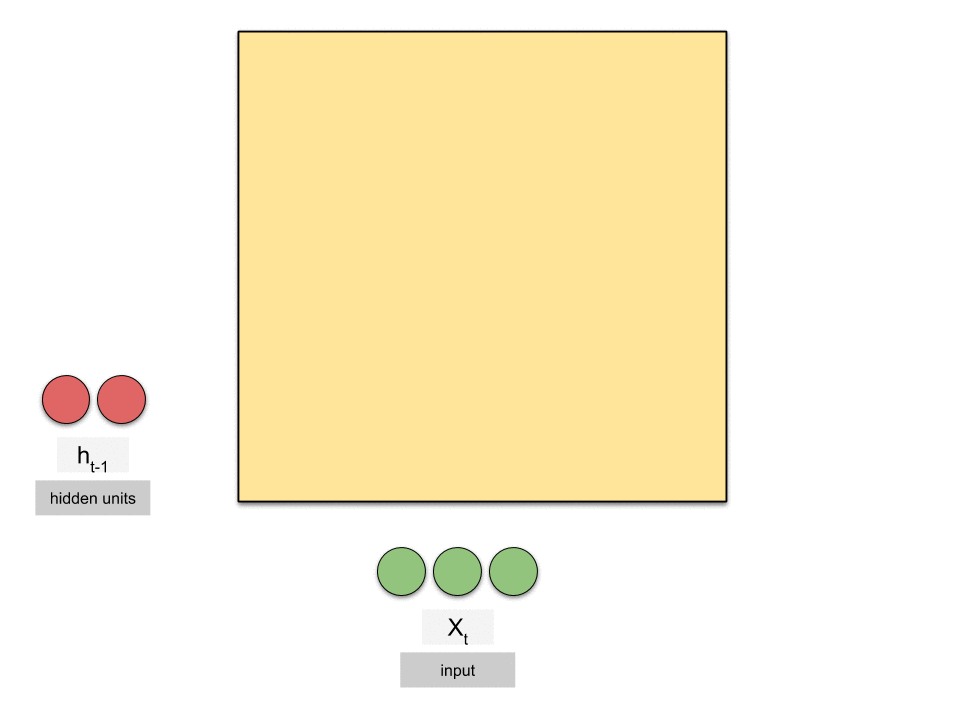

count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
25%          6.000000
50%         10.000000
75%         22.000000
max        113.000000
dtype: float64

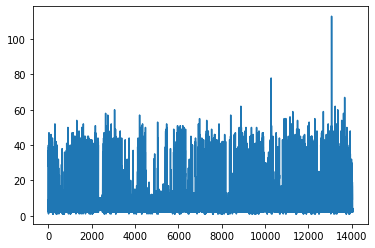

In [5]:
import pandas as pd
import numpy as np


max_lens = list()
for row in dataset_base['train']:
    max_lens.append(len(row['tokens']))
max_lens = pd.Series(max_lens)
max_lens.plot();
max_lens.describe()

In [6]:
import json
mapping_ = {v: k for k, v in dataset_base["train"].features["ner_tags"].feature._str2int.items()}

with open('mapping.json', 'w') as f:
  json.dump(mapping_, f)
mapping_

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 7: 'B-MISC',
 8: 'I-MISC'}

In [7]:
def get_word_to_idx(count: List[Tuple[str, int]],
                   min_words: Union[int, float] = 0.0,
                   max_words: Union[int, float] = 1.0) -> Dict[str, int]:
    max_count = count[0][1]
    if isinstance(min_words, float):
        min_words = max_count * min_words
    if isinstance(max_words, float):
        max_words = max_count * max_words
        
    all_words = [w[0] for w in count if max_words >= w[1] >= min_words]
    
    all_words = ['<pad>', '<unk>'] + all_words
    
    word_to_idx = {k: v for k, v in zip(all_words, range(0, len(all_words)))}
    return word_to_idx

In [8]:
count = Counter([i.lower() for j in dataset_base['train'] for i in j['tokens']])
word_to_idx = get_word_to_idx(count.most_common(), min_words=1)
len(word_to_idx)

21011

In [9]:
def create_matrix_of_texts(dataset, max_sequence_length, 
                           pad_token, word2index):
    texts = np.full((len(dataset), max_sequence_length),
                    word2index[pad_token], dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['tokens']))
          text = row['tokens'][: trim_length]
          texts[ind, : trim_length] = [word2index[item.lower()] for item in text]
    return texts


def create_matrix_of_tags(dataset, max_sequence_length, pad_index):
    tags = np.full((len(dataset), max_sequence_length),
                    pad_index, dtype=np.int64)  # creating empty matrix

    for ind, row in enumerate(dataset):
          trim_length = min(max_sequence_length, len(row['ner_tags']))
          labels = row['ner_tags'][: trim_length]
          tags[ind, : trim_length] = [item for item in labels]
    return tags

In [10]:
texts = create_matrix_of_texts(dataset_base['train'], 
                               int(max_lens.quantile(0.97)),
                               '<pad>', word_to_idx)
tags = create_matrix_of_tags(dataset_base['train'],
                             int(max_lens.quantile(0.97)), 0)

In [11]:
class NerDataset(Dataset):
    def __init__(self,
                 texts: np.array,
                 tags: np.array):
        self.tags = tags
        self.texts = texts
        

    def __getitem__(self, idx: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens_tensor = torch.tensor(self.texts[idx], dtype=torch.int64)
        return tokens_tensor, torch.tensor(self.tags[idx], dtype=torch.int64)

    def __len__(self) -> int:
        dataset_len = self.texts.shape[0]
        return dataset_len

In [12]:
dataset = dataset_base['train']
ner_dataset = NerDataset(texts, tags)
assert len(ner_dataset) == 14041

In [13]:
' '.join(dataset_base['train'][0]['tokens']), ner_dataset[0]

('EU rejects German call to boycott British lamb .',
 (tensor([  989, 10951,   205,   629,     7,  3939,   216,  5774,     3,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
  tensor([3, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])))

In [14]:
dataset = dataset_base["train"]
ner_dataset = NerDataset(texts, tags)
tokens, labels = ner_dataset[0]
assert isinstance(tokens, LongTensor)
assert isinstance(labels, LongTensor)
assert tokens.shape == labels.shape
tokens, labels = ner_dataset[2]
assert tokens.shape == labels.shape

In [15]:
from torch.utils.data.dataset import random_split

In [16]:
BATCH_SIZE = 32

In [17]:
num_train = int(len(ner_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(ner_dataset, [num_train, len(ner_dataset) - num_train])

train_dataloader = torch.utils.data.DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, drop_last=True)
valid_dataloader = torch.utils.data.DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False)

In [18]:
class NerRNNModel(nn.Module):
    def __init__(
        self,
        word2idx: Dict,
        embedding_dim: int = 100,
        mapping: Dict[int, str] = None,
        hidden_size: int = 256
    ):
        super(NerRNNModel, self).__init__()
        if not mapping:
            raise RuntimeError(f'Empty labels')
        self.word2idx = word2idx
        self.labels = mapping
        self.embedding = nn.Embedding(len(word_to_idx), embedding_dim)
        self.encoder = nn.RNN(
            embedding_dim,
            hidden_size,
            batch_first=True
        )
        self.projection = nn.Linear(hidden_size, len(mapping))

    def forward(self, tokens: LongTensor) -> FloatTensor:

        emb = self.embedding(tokens)        
        h, _ = self.encoder(emb)
        pred = self.projection(h)
        return pred.view(-1, len(self.labels))

In [19]:
model = NerRNNModel(word_to_idx, 100, {idx: str(idx) for idx in range(10)})
assert (
        len(list(name for name, module in model.named_modules())) > 3
    ), "Not enough layers created"

In [20]:
num_classes = 9
model = NerRNNModel(word_to_idx, 30, {idx: str(idx) for idx in range(num_classes)})
seq_len = 32
example_input = torch.randint(0, 2, (BATCH_SIZE, seq_len), dtype=torch.int64)
logits = model(example_input)
assert isinstance(logits, torch.FloatTensor)
assert logits.shape == (BATCH_SIZE * seq_len, num_classes), f"current size of model output {logits.shape}"

In [21]:
i = iter(train_dataloader)
text, label = next(i)
logits = model(text)
loss_function = nn.CrossEntropyLoss()
loss_function(logits, label.view(-1))

tensor(2.2589, grad_fn=<NllLossBackward>)

### trainig

In [22]:
from sklearn.metrics import classification_report

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    correct_labels = [value for value in mapping_.values() if value != 'O']
    predicted, true_labels = list(), list()

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            tokens, label = batch
            tokens = tokens.to(device)
            
            logits = model(tokens)
            predictions = F.log_softmax(logits, dim=1).reshape(-1,
                                                               40,
                                                               len(mapping_)).argmax(dim=2).flatten().detach().cpu().numpy()
            predicted.extend(predictions)
            true_labels.extend(label.flatten().detach().cpu().numpy())
    
    true_labels = [mapping_[val] for val in true_labels]
    
    predicted = [mapping_[val] for val in predicted]
    print('\n', classification_report(true_labels,
                                      predicted,
                                      labels=correct_labels))

In [23]:
model = NerRNNModel(word_to_idx, 300, mapping_)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

NerRNNModel(
  (embedding): Embedding(21011, 300)
  (encoder): RNN(300, 256, batch_first=True)
  (projection): Linear(in_features=256, out_features=9, bias=True)
)

In [24]:
sum([params.numel() for params in model.parameters() if params.requires_grad])

6448461

In [25]:
for e in range(6):
    total_loss = 0
    model.train()
    loss_function = nn.CrossEntropyLoss()
    for sent in tqdm(train_dataloader):

            # (1) Set gradient to zero for new example: Set gradients to zero before pass
            model.zero_grad()
            
            # (2) Encode sentence and tag sequence as sequences of indices
            input_sent, gold_tags = sent

            # (3) Predict tags (sentence by sentence)
            if len(input_sent) > 0:
                pred_scores = model(input_sent.to(device))
                mask = gold_tags != 0
                # (4) Compute loss and do backward step
                loss = loss_function(pred_scores.to(device), gold_tags.view(-1).to(device))
                loss.backward()
              
                # (5) Optimize parameter values
                optimizer.step()
          
                # (6) Accumulate loss
                total_loss += loss
    print('\nEpoch: %d, loss: %.4f' % (e, total_loss / len(train_dataloader)))
    evaluate(valid_dataloader)

100%|██████████| 416/416 [00:04<00:00, 86.41it/s]



Epoch: 0, loss: 0.1629

               precision    recall  f1-score   support

       B-PER       0.66      0.81      0.73       312
       I-PER       0.74      0.88      0.81       198
       B-ORG       0.80      0.50      0.62       347
       I-ORG       0.75      0.37      0.50       180
       B-LOC       0.78      0.80      0.79       319
       I-LOC       0.56      0.52      0.54        54
      B-MISC       0.74      0.72      0.73       145
      I-MISC       0.52      0.37      0.43        46

   micro avg       0.73      0.67      0.70      1601
   macro avg       0.69      0.62      0.64      1601
weighted avg       0.73      0.67      0.69      1601



100%|██████████| 416/416 [00:04<00:00, 91.73it/s]



Epoch: 1, loss: 0.0542

               precision    recall  f1-score   support

       B-PER       0.76      0.87      0.81       312
       I-PER       0.86      0.86      0.86       198
       B-ORG       0.76      0.69      0.73       347
       I-ORG       0.73      0.62      0.67       180
       B-LOC       0.80      0.85      0.83       319
       I-LOC       0.72      0.63      0.67        54
      B-MISC       0.74      0.72      0.73       145
      I-MISC       0.62      0.46      0.52        46

   micro avg       0.77      0.77      0.77      1601
   macro avg       0.75      0.71      0.73      1601
weighted avg       0.77      0.77      0.77      1601



100%|██████████| 416/416 [00:04<00:00, 91.84it/s]



Epoch: 2, loss: 0.0361

               precision    recall  f1-score   support

       B-PER       0.87      0.85      0.86       312
       I-PER       0.86      0.89      0.88       198
       B-ORG       0.84      0.70      0.76       347
       I-ORG       0.65      0.66      0.66       180
       B-LOC       0.82      0.83      0.83       319
       I-LOC       0.70      0.52      0.60        54
      B-MISC       0.63      0.83      0.72       145
      I-MISC       0.36      0.70      0.47        46

   micro avg       0.77      0.78      0.78      1601
   macro avg       0.72      0.75      0.72      1601
weighted avg       0.79      0.78      0.78      1601



100%|██████████| 416/416 [00:04<00:00, 91.48it/s]



Epoch: 3, loss: 0.0299

               precision    recall  f1-score   support

       B-PER       0.87      0.84      0.85       312
       I-PER       0.93      0.84      0.88       198
       B-ORG       0.78      0.73      0.75       347
       I-ORG       0.68      0.60      0.64       180
       B-LOC       0.80      0.87      0.83       319
       I-LOC       0.68      0.72      0.70        54
      B-MISC       0.70      0.77      0.73       145
      I-MISC       0.75      0.59      0.66        46

   micro avg       0.80      0.78      0.79      1601
   macro avg       0.77      0.74      0.76      1601
weighted avg       0.80      0.78      0.78      1601



100%|██████████| 416/416 [00:04<00:00, 92.01it/s]



Epoch: 4, loss: 0.0265

               precision    recall  f1-score   support

       B-PER       0.89      0.84      0.86       312
       I-PER       0.87      0.87      0.87       198
       B-ORG       0.78      0.75      0.77       347
       I-ORG       0.67      0.73      0.70       180
       B-LOC       0.86      0.84      0.85       319
       I-LOC       0.64      0.67      0.65        54
      B-MISC       0.79      0.81      0.80       145
      I-MISC       0.84      0.59      0.69        46

   micro avg       0.81      0.80      0.80      1601
   macro avg       0.79      0.76      0.77      1601
weighted avg       0.82      0.80      0.80      1601



100%|██████████| 416/416 [00:04<00:00, 91.69it/s]



Epoch: 5, loss: 0.0251

               precision    recall  f1-score   support

       B-PER       0.85      0.83      0.84       312
       I-PER       0.92      0.85      0.88       198
       B-ORG       0.87      0.76      0.81       347
       I-ORG       0.75      0.61      0.67       180
       B-LOC       0.88      0.83      0.85       319
       I-LOC       0.66      0.70      0.68        54
      B-MISC       0.71      0.79      0.75       145
      I-MISC       0.81      0.54      0.65        46

   micro avg       0.84      0.78      0.80      1601
   macro avg       0.81      0.74      0.77      1601
weighted avg       0.84      0.78      0.80      1601



In [27]:
RNN(num_layers)

NameError: ignored